In [5]:
### # Building a Mean-Reverting Algorithmic Trading Strategy Using Cointegration

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use('ggplot')

symbols = ['AAPL', 'TSLA']

prices_df = yf.download(tickers=symbols, start = '2020-01-01', end = '2023-01-01')['Adj Close']

prices_df['aapl_ret']  = np.log(prices_df['AAPL']).diff()

prices_df['goog_ret']  = np.log(prices_df['TSLA']).diff()

prices_df = prices_df.dropna()

score, pvalue, level = coint(prices_df['aapl_ret'], prices_df['goog_ret'], trend='c', autolag='BIC')

print(f'p-value: {pvalue}')
print(f'score: {score}')
print(f'levels: {level}')

[*********************100%***********************]  2 of 2 completed
p-value: 0.0
score: -30.817667390439972
level: [-3.91102404 -3.34424558 -3.05007972]


<AxesSubplot:xlabel='Date'>

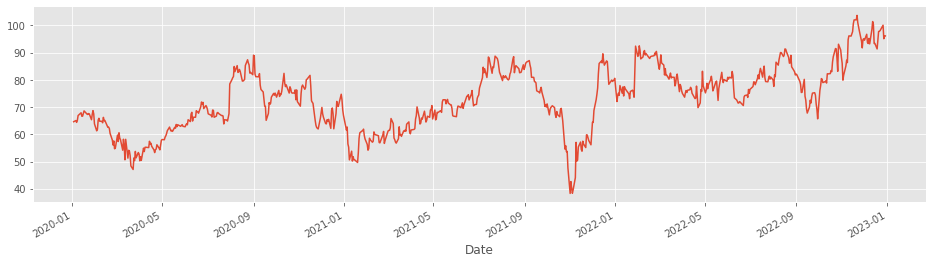

In [2]:
# 1. Fit a regression and form the spread

beta = sm.OLS(prices_df['aapl_ret'], prices_df['goog_ret']).fit().params[0]

prices_df['spread'] = (prices_df['AAPL'] - beta * prices_df['TSLA']).to_frame('aapl_goog_spread')

prices_df['spread'].plot(figsize=(16,4))

In [ ]:
###     # Smooth the spread with Z-score 

def smooth_zscore(spread):
    zscore = (spread.rolling(window=12).mean()-spread.rolling(window=50).mean())/spread.rolling(window=50).std()
    return zscore
        
prices_df['zscored'] = smooth_zscore(spread=prices_df['spread'])
        

In [ ]:
prices_df['zscored'].plot(figsize=(16,4))

plt.axhline(1.2, color='k', ls='-')

plt.axhline(-1.2, color='k', ls='-')

plt.show()

In [ ]:
# Calculate the signal. 
# When the spread is above 1.2 we short the spread. 
# When the spread is below -1.2 we long the spread.

prices_df['signal'] = prices_df['zscored'].apply(lambda x: 1 if (x>1.2) else (-1 if (x<-1.2) else np.nan))

prices_df['signal'] = prices_df['signal'].ffill()

prices_df['strategy_return'] = prices_df.apply(lambda x: (x['goog_ret']-x['aapl_ret']) if x['signal']==1
                                               else ((x['aapl_ret']-x['goog_ret']) if x['signal']==-1 else 0), axis=1)

prices_df = prices_df.dropna()

prices_df

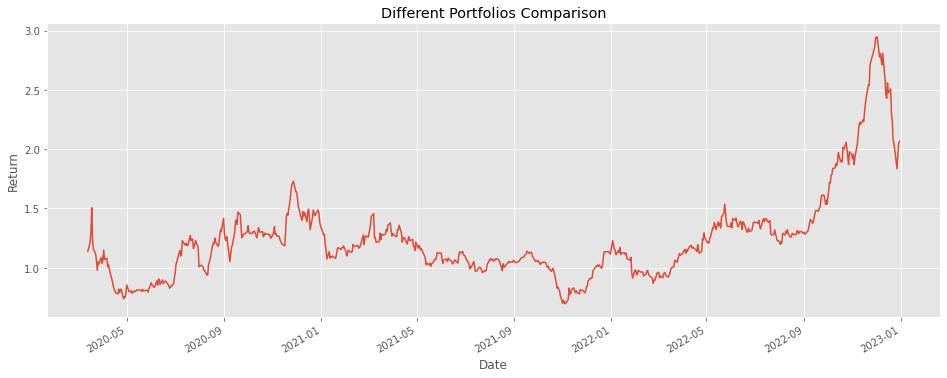

In [104]:
# Plot the cumulative returns

plt.style.use('ggplot')

portfolios_cummulative_return = np.exp(np.log1p(prices_df['strategy_return']).cumsum())

portfolios_cummulative_return.plot(figsize=(16,6))

plt.title('Different Portfolios Comparison')

plt.ylabel('Return')

plt.show()